<a href="https://colab.research.google.com/github/vvjft/DL_BIQA/blob/main/CNNIQA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Dependencies**

In [1]:
import tensorflow as tf
import numpy as np
import scipy
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

!apt-get install unrar

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


##### Download and extract dataset

In [2]:
!wget https://www.ponomarenko.info/tid2013/tid2013.rar # tid2013

from google.colab import drive
drive.mount('/content/drive') # LIVE

--2024-06-03 21:59:32--  https://www.ponomarenko.info/tid2013/tid2013.rar
Resolving www.ponomarenko.info (www.ponomarenko.info)... 91.108.100.61, 2a02:4780:1e:792:11b:c760:9707:748d
Connecting to www.ponomarenko.info (www.ponomarenko.info)|91.108.100.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 957680241 (913M) [application/x-rar-compressed]
Saving to: ‘tid2013.rar’

tid2013.rar         100%[===================>] 913.31M  60.1MB/s    in 16s     

2024-06-03 21:59:49 (57.4 MB/s) - ‘tid2013.rar’ saved [957680241/957680241]

Mounted at /content/drive


In [3]:
!mkdir -p '/content/tid2013'
!unrar x -inul '/content/tid2013.rar' '/content/tid2013'
!rm '/content/tid2013.rar'
!rm -r '/content/tid2013/metrics_values'
!rm -r '/content/tid2013/papers'
!rm '/content/tid2013/readme'
!rm -r '/content/sample_data'

!cp -r /content/drive/MyDrive/magisterka/LIVEIQA_release2 /content
os.rename('/content/LIVEIQA_release2', '/content/LIVE')
drive.flush_and_unmount()

Reset workspace or directory if needed

In [15]:
#!rm -r '/content/LIVE/normalized_distorted_images'
#!rm -r '/content/tid2013'
#!rm -r '/content/tid2013/patch_mos_with_names.csv'

#%reset -f

### **Preprocessing**

##### Logistic mapping

In [4]:
from scipy.optimize import curve_fit

def logistic_function(x, a, b, c, d):
    return a / (1 + np.exp(-c * (x - d))) + b

def get_logistic_fun(data_tid, data_live):
  def convert_mos_to_dmos(mos, dmos):
      initial_params = [0, 0, 0, np.median(mos)]  # initial guess for parameters
      popt, _ = curve_fit(logistic_function, mos, dmos, p0=initial_params, maxfev=10000)
      return popt

  train_data_tid, val_data_tid, test_data_tid = split_data(data_tid)
  train_data_live, val_data_live, test_data_live = split_data(data_live)
  # Align MOS and DMOS for fitting
  mos_train = np.sort(train_data_tid['MOS'].values)
  dmos_train = np.sort(train_data_live['DMOS'].values[:len(mos_train)])[::-1]  # ensure lengths match for curve fitting

  params = convert_mos_to_dmos(mos_train, dmos_train)
  #print("Estimated parameters:", params)
  data_tid['DMOS_pred'] = logistic_function(data_tid['MOS'].values, *params)

  plt.scatter(data_tid['MOS'], data_tid['DMOS_pred'], label='Predicted DMOS', alpha=0.5)
  plt.scatter(mos_train, dmos_train, label='Actual DMOS (Training Data)', alpha=0.5)
  plt.title('Logistic mapping (MOS to DMOS)')
  plt.xlabel('MOS')
  plt.ylabel('DMOS')
  plt.legend()
  plt.grid(True)
  plt.show()

  return params

##### Normalize and slice to patches

In [5]:
from scipy.signal import convolve2d
def normalize_and_slice(db_dir, train_data, val_data, test_data, patch_size=32, cross=False):

  def local_normalize(patch, P=3, Q=3, C=1):
      kernel = np.ones((P, Q)) / (P * Q)
      patch_mean = convolve2d(patch, kernel, boundary='symm', mode='same')
      patch_sm = convolve2d(np.square(patch), kernel, boundary='symm', mode='same')
      patch_std = np.sqrt(np.maximum(patch_sm - np.square(patch_mean), 0)) + C
      patch_ln = (patch - patch_mean) / patch_std
      return patch_ln.astype('float32')

  sets = {'train': [train_data, 'training'], 'val':[val_data, 'validation'], 'test':[test_data, 'test']}

  for key, (data, name) in sets.items():
    if cross==True and name=='test':
      db_dir = 'tid2013'

    output_dir_full = f'{db_dir}/normalized_distorted_images/{name}/full/' # where to store normalized distorted images
    output_dir_patches = f'{db_dir}/normalized_distorted_images/{name}/patches/' # where to store patches
    norm_file_info_path = f'{db_dir}/normalized_distorted_images/{name}/norm_{name}.csv'
    patch_file_info_path = f'{db_dir}/normalized_distorted_images/{name}/patch_{name}.csv'
    os.makedirs(output_dir_full, exist_ok=True)
    os.makedirs(output_dir_patches, exist_ok=True)

    norm_info_list = []
    patch_info_list = []

    for index, row in data.iterrows():
        image_filename = row[0]
        mos_value = row[1]
        distortion = row[2]
        image_path = f'{db_dir}/distorted_images/{image_filename}'
        image = cv2.imread(image_path)

        if image is None:
            print(f"Failed to load image: {image_filename}")
            continue

        # Normalize the image
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image_normalized = local_normalize(image_gray)
        # Save
        image_filename = f'NORM_{image_filename}'
        norm_info_list.append([image_filename, mos_value, distortion])
        cv2.imwrite(output_dir_full+image_filename, image_normalized)
        # Slice to patches
        height, width = image_normalized.shape[:2]
        num_patches_y = height // patch_size
        num_patches_x = width // patch_size
        patch_count = 0
        for i in range(num_patches_y):
            for j in range(num_patches_x):
                patch = image_normalized[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
                patch_path = os.path.join(output_dir_patches, f"{os.path.splitext(image_filename)[0]}_patch_{patch_count}.bmp")
                patch_filename = f"{os.path.splitext(image_filename)[0]}_patch_{patch_count}.bmp"
                cv2.imwrite(patch_path, patch)
                # Add patch info to the list
                patch_info_list.append([patch_filename, mos_value, distortion])
                patch_count += 1

    norm_info_df = pd.DataFrame(norm_info_list, columns=['image_filename', score_measure, 'Distortion'])
    norm_info_df.to_csv(norm_file_info_path, index=False)
    print(f"[{name}]: Saved full normalized distorted image info to:\n{patch_file_info_path}.")
    patch_info_df = pd.DataFrame(patch_info_list, columns=['image_filename', score_measure, 'Distortion'])
    patch_info_df.to_csv(patch_file_info_path, index=False)
    print(f"[{name}]: Saved patch info to {patch_file_info_path}.")

##### Divide dataset

In [13]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

def load_tid2013(base_dir, filter=False):
    distortion_mapping = {1: 'wn', 8: 'blur', 10: 'jpeg', 11: 'jp2k'}
    data_path = os.path.join(base_dir, 'mos_with_names.txt')
    data = pd.read_csv(data_path, header=None, delimiter=' ')
    data = data.iloc[:, [1, 0]]  # swap column order
    data.columns = ['image_filename', 'MOS']
    # Specify distortion type based on filename
    data['Distortion'] = data['image_filename'].apply(lambda x: distortion_mapping.get(int(x.split('_')[1]), 'other'))
    if filter:
        data = data[data['Distortion'].isin(distortion_mapping.values())]
    return data

def load_live(base_dir, filter=False):
    data_path = os.path.join(base_dir, 'dmos_with_names.csv')
    data = pd.read_csv(data_path, index_col=False)
    if filter:
      distortion_types = [1, 2, 3, 4] # filter distortions: jp2k, jpeg, wn and blur
      data = data[data['image_filename'].apply(lambda x: int(x.split('_')[1]) in distortion_types)]
    return data

def split_data(data1, data2=None, params=None, cross=False):
    if cross==True:
      train_data, val_data = train_test_split(data1, test_size=0.2, random_state=40)
      predicted_dmos = logistic_function(data2['MOS'].values, *params)
      test_data = data2
      test_data['MOS'] = predicted_dmos
      test_data.rename(columns={'MOS':'DMOS'}, inplace=True)
      return train_data, val_data, test_data
    else:
      train_data, test_data = train_test_split(data1, test_size=0.2, random_state=40)
      train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=40)
      return train_data, val_data, test_data

tid2013_dir = 'tid2013'
live_dir = 'LIVE'
db_dir = live_dir
cross = False
score_measure = 'DMOS' if db_dir == live_dir or cross == True else 'MOS'

data_tid = load_tid2013(tid2013_dir, filter=True)
data_tid.to_csv('tid2013/mos_with_names.csv', index=False)
data_live = load_live(live_dir, filter=cross)
data_live.to_csv('LIVE/dmos_with_names.csv', index=False)

if cross == False:
  '''Choose database to evaluate'''
  data = data_live if db_dir == live_dir else data_tid
  train_data, val_data, test_data = split_data(data)
  normalize_and_slice(db_dir, train_data, val_data, test_data)

  train_data = pd.read_csv(f'{db_dir}/normalized_distorted_images/training/patch_training.csv')
  val_data = pd.read_csv(f'{db_dir}/normalized_distorted_images/validation/patch_validation.csv')
  test_data = pd.read_csv(f'{db_dir}/normalized_distorted_images/test/patch_test.csv')
else:
  '''or perform cross validation'''
  params = get_logistic_fun(data_tid, data_live)
  train_data, val_data, test_data = split_data(data_live, data_tid, params, cross) # cross validation (TID2013 as test)
  normalize_and_slice(db_dir, train_data, val_data, test_data, cross)

  train_data = pd.read_csv(f'LIVE/normalized_distorted_images/training/patch_training.csv')
  val_data = pd.read_csv(f'LIVE/normalized_distorted_images/validation/patch_validation.csv')
  test_data = pd.read_csv(f'tid2013/normalized_distorted_images/test/patch_test.csv')

[training]: Saved full normalized distorted image info to:
LIVE/normalized_distorted_images/training/patch_training.csv.
[training]: Saved patch info to LIVE/normalized_distorted_images/training/patch_training.csv.
[validation]: Saved full normalized distorted image info to:
LIVE/normalized_distorted_images/validation/patch_validation.csv.
[validation]: Saved patch info to LIVE/normalized_distorted_images/validation/patch_validation.csv.
[test]: Saved full normalized distorted image info to:
LIVE/normalized_distorted_images/test/patch_test.csv.
[test]: Saved patch info to LIVE/normalized_distorted_images/test/patch_test.csv.


###### Validate the division

In [17]:
# Paths to the CSV files
norm_training_csv = f'{db_dir}/normalized_distorted_images/training/norm_training.csv'
norm_validation_csv = f'{db_dir}/normalized_distorted_images/validation/norm_validation.csv'
norm_test_csv = f'{db_dir}/normalized_distorted_images/test/norm_test.csv'

# Read the CSV files
norm_training_df = pd.read_csv(norm_training_csv)
norm_validation_df = pd.read_csv(norm_validation_csv)
norm_test_df = pd.read_csv(norm_test_csv)

# Extract the lists of filenames
training_files = set(norm_training_df['image_filename'])
validation_files = set(norm_validation_df['image_filename'])
test_files = set(norm_test_df['image_filename'])

# Check for common files
common_training_validation = training_files.intersection(validation_files)
common_training_test = training_files.intersection(test_files)
common_validation_test = validation_files.intersection(test_files)

# Print the results
if not common_training_validation and not common_training_test and not common_validation_test:
    print("There are no common files between norm_training, norm_validation, and norm_test.")
else:
    if common_training_validation:
        print(f"Common files between training and validation: {common_training_validation}")
    if common_training_test:
        print(f"Common files between training and test: {common_training_test}")
    if common_validation_test:
        print(f"Common files between validation and test: {common_validation_test}")


There are no common files between norm_training, norm_validation, and norm_test.


##### Load data into tensorflow data generators

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_data_generators(base_dir, train_data, val_data, test_data, batch_size):
    datagen = ImageDataGenerator()
    train_generator = datagen.flow_from_dataframe(
        dataframe=train_data,
        directory=os.path.join(base_dir, 'training/patches/'),
        x_col='image_filename',
        y_col=score_measure,
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='raw',
        shuffle=True,
        seed=42
    )
    val_generator = datagen.flow_from_dataframe(
        dataframe=val_data,
        directory=os.path.join(base_dir, 'validation/patches/'),
        x_col='image_filename',
        y_col=score_measure,
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='raw',
        shuffle=True,
        seed=42
    )
    if cross == True:
      base_dir = 'tid2013/normalized_distorted_images'
    test_generator = datagen.flow_from_dataframe(
        dataframe=test_data,
        directory=os.path.join(base_dir, 'test/patches/'),
        x_col='image_filename',
        y_col=score_measure,
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='raw',
        shuffle=False,
        seed=42
    )
    return train_generator, val_generator, test_generator

base_dir = f'{db_dir}/normalized_distorted_images'
train_generator, val_generator, test_generator = create_data_generators(base_dir, train_data, val_data, test_data, batch_size=32)


Found 161332 validated image filenames.
Found 53196 validated image filenames.
Found 53332 validated image filenames.


### **Define and train the model**

##### Network architecture

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, GlobalMaxPooling2D, Dense, Dropout

def build_model():
    model = Sequential([
        Conv2D(50, (7, 7), activation='relu', input_shape=(32, 32, 3)), # linear in the paper
        GlobalMaxPooling2D(),
        Dense(800, activation='relu'),
        #Dropout(0.5),  # Add dropout to prevent overfitting
        Dense(800, activation='relu'),
        Dropout(0.5),  # Add dropout to prevent overfitting
        Dense(1, activation='linear')  # Output layer for the quality score
    ])
    return model

model = build_model()
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 26, 26, 50)        7400      
                                                                 
 global_max_pooling2d_1 (Gl  (None, 50)                0         
 obalMaxPooling2D)                                               
                                                                 
 dense_3 (Dense)             (None, 800)               40800     
                                                                 
 dense_4 (Dense)             (None, 800)               640800    
                                                                 
 dropout_1 (Dropout)         (None, 800)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 801       
                                                      

#### Training

In [16]:
history = model.fit(train_generator, epochs=1, validation_data=val_generator)

5042/5042 [==============================] - 110s 22ms/step - loss: 318.4034 - mean_absolute_error: 13.4671 - val_loss: 326.9117 - val_mean_absolute_error: 13.4311


### **Summarize predictions**

##### Predict DMOS/MOS score

In [17]:
test_predictions = model.predict(test_generator)
patch_info = test_generator.filenames # get list of test patches
image_scores = {}
for i, patch_path in enumerate(patch_info):
    # Extract the base image name by removing the patch-specific part
    base_image_name = "_".join(patch_path.split('_')[0:-2]) + '.bmp'
    if base_image_name not in image_scores:
        image_scores[base_image_name] = []
    image_scores[base_image_name].append(test_predictions[i])

average_scores = {image: np.mean(scores) for image, scores in image_scores.items()}
average_scores_df = pd.DataFrame(list(average_scores.items()), columns=['Image', f'Predicted_{score_measure}'])
print("Summary of test predictions:")
print(average_scores_df.describe())

if cross == True:
  db_dir = tid2013_dir
test_images_score = pd.read_csv(f'{db_dir}/normalized_distorted_images/test/norm_test.csv')
test_images_score.rename(columns={'image_filename':'Image', score_measure:score_measure, 'Distortion':'Distortion'}, inplace=True)

# Force all extensions to be '.bmp' (there are inconsitencies between mos_with_names.txt and actual filename: '.bmp' vs '.BMP')
test_images_score['Image'] = test_images_score['Image'].apply(lambda x: x.lower())
average_scores_df['Image'] = average_scores_df['Image'].apply(lambda x: x.lower())

# Merge dataframes to match predicted mos with ground-truth score
merged_df = average_scores_df.merge(test_images_score, on="Image", how="inner")
merged_df.rename(columns={f'Predicted_{score_measure}_x': f'Predicted_{score_measure}', f'Predicted_{score_measure}_y': {score_measure}}, inplace=True)
merged_df['Image'] = merged_df['Image'].str.replace('norm_', '')
print(merged_df)

1667/1667 [==============================] - 22s 13ms/step
Summary of test predictions:
       Predicted_DMOS
count      156.000000
mean        47.429314
std         19.725142
min         19.294331
25%         31.368154
50%         46.600449
75%         61.030989
max         97.276245
                        Image  Predicted_DMOS       DMOS  Distortion
0         lighthouse2_4_5.bmp       21.236300  24.912864       gblur
1               plane_5_1.bmp       46.859715  49.804950  fastfading
2               house_3_2.bmp       23.954910  20.527485          wn
3             cemetry_2_4.bmp       22.122496  24.492693        jpeg
4             cemetry_1_1.bmp       62.552845  73.091742        jp2k
..                        ...             ...        ...         ...
151          sailing2_3_2.bmp       23.714762  21.610529          wn
152           parrots_4_1.bmp       36.594158  23.747801       gblur
153             house_3_1.bmp       53.154911  66.531650          wn
154          womanhat_3_

##### Calculate correlations

In [18]:
from scipy.stats import spearmanr, pearsonr
# Drop NaN or inf values if present
cleaned_df = merged_df.dropna()
cleaned_df = cleaned_df[np.isfinite(cleaned_df[score_measure]) & np.isfinite(cleaned_df[f'Predicted_{score_measure}'])]

# Calculate LCC and SROCC
lcc = pearsonr(cleaned_df[f'Predicted_{score_measure}'], cleaned_df[score_measure])[0]
srocc = spearmanr(cleaned_df[f'Predicted_{score_measure}'], cleaned_df[score_measure])[0]

print('All:')
print(f"  LCC (Linear Correlation Coefficient): {lcc}")
print(f"  SROCC (Spearman Rank Order Correlation Coefficient): {srocc}")

# Calculate LCC and SROCC for each distortion
grouped = cleaned_df.groupby('Distortion')

for name, group in grouped:
    group_lcc = pearsonr(group[f'Predicted_{score_measure}'], group[score_measure])[0]
    group_srocc = spearmanr(group[f'Predicted_{score_measure}'], group[score_measure])[0]
    print(f"Distortion: {name}")
    print(f"  LCC: {group_lcc}")
    print(f"  SROCC: {group_srocc}")

All:
  LCC (Linear Correlation Coefficient): 0.9214623029039487
  SROCC (Spearman Rank Order Correlation Coefficient): 0.9213975766132515
Distortion: fastfading
  LCC: 0.8877420787766147
  SROCC: 0.9203559510567296
Distortion: gblur
  LCC: 0.9140712488319042
  SROCC: 0.9305418719211821
Distortion: jp2k
  LCC: 0.9002234799056128
  SROCC: 0.9043255131964808
Distortion: jpeg
  LCC: 0.9663816033176841
  SROCC: 0.9495004878844914
Distortion: wn
  LCC: 0.985218616361138
  SROCC: 0.9857752489331436


##### Visualize correletions and training

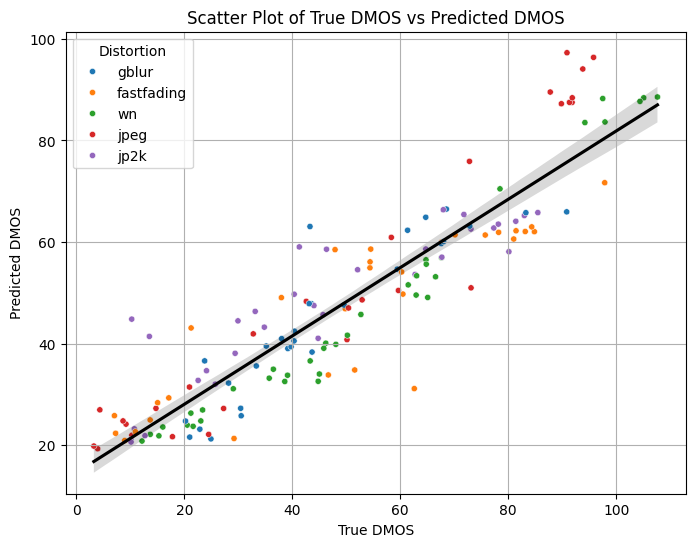

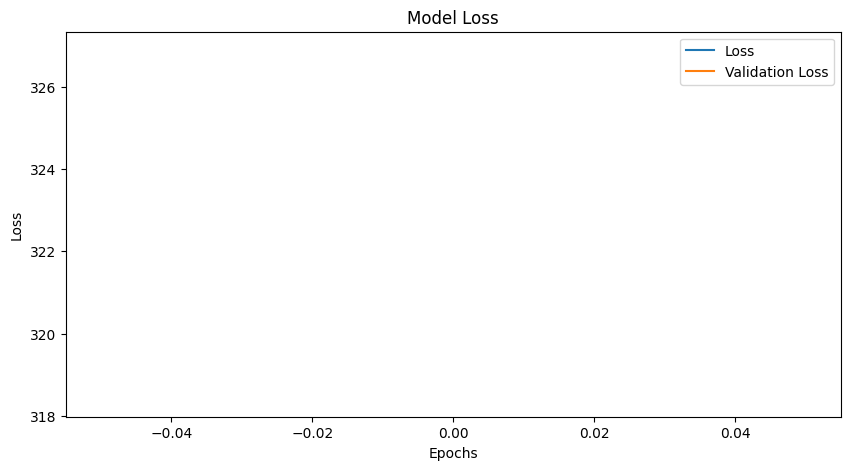

In [19]:
# Scatter plot with regression line
plt.figure(figsize=(8, 6))
sns.scatterplot(x=score_measure, y=f'Predicted_{score_measure}', data=merged_df, hue='Distortion', palette='tab10', s=20)
sns.regplot(x=score_measure, y=f'Predicted_{score_measure}', data=merged_df, scatter=False, line_kws={'color': 'black'})
plt.xlabel(f'True {score_measure}')
plt.ylabel(f'Predicted {score_measure}')
plt.title(f'Scatter Plot of True {score_measure} vs Predicted {score_measure}')
plt.grid(True)
plt.show()

y_pred = test_predictions
y_true = test_generator.labels
# Training progress (loss minimization)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()